## Exploration with Word Embedings (Deep Learning)

### Anatomy of Word2Vec
* The input represents our vocabulary.
* The word embedding are actually the hidden layer after traning. This layer is set to the dimensionality of the resulting word vectors. 
* The output is the context given the word or the word given the context.
#### Note there is no activation function in the hidden layer which we refer to as linear activation.
<BR>
<img src="./images/word2vec.png" width=600>
<BR>
<img src="./images/w2v-contexts.png" width=600>

### Continuous Bag of Words (CBOW) Learning
#### Embedding Model p(word | context)
#### Advantages: Smooths over distribution by averaging over all context words. This is helpful for small training sets.
####                        Also faster
<BR>   
<img src="./images/CBOW.png" width="300"> 

### Skipgram 
#### Model p(context | word) 
#### Advantage: Learns finer-grained vectors on large training data (i.e. better with infrequent words)
<img src="./images/Skip-Gram.png" width=300>

In [3]:
import nltk
import pickle as pkl
import pandas as pd
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import sklearn
from sklearn.manifold import TSNE
%matplotlib inline 
import matplotlib.pyplot as plt

## More Environment Setup

#### We also need to load some nltk resources. These resources will help us clean the data.

In [5]:
# Text contains a lot of noisy words that are simply there to help with fluency.
nltk.set_proxy('http://proxy.ihc.com:8080', ('jferraro', ''))
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jferraro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Syntactic NLP Processing

#### We want to coustomize tokenization so we have more control over our text and can remove unique textual forms of noise like dates, ages, etc.

In [6]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def doc_to_clean_sentences(doc, vocab):
    clean_lines = list()
    lines = doc.splitlines()
    for line in lines:
        # split into tokens by white space
        tokens = line.lower().split()
        # remove punctuation from each token
        table = str.maketrans('', '', punctuation)
        tokens = [w.translate(table) for w in tokens]
        # filter out tokens not in vocab
        tokens = [w for w in tokens if w in vocab]
        if tokens:
            clean_lines.append(tokens)
    return clean_lines

## Get our Corpus and Vocabulary

#### Let's pull in our corpus that we had serialized out to disk.

In [7]:
file = open('data/differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()

In [8]:
# load the vocabulary
vocab_filename = 'data\pna_vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [13]:
type(corpus)

collections.OrderedDict

## Data Structure Transformation

#### Let's build a dataframe so we can select case types easily.

In [14]:
df = pd.DataFrame(columns=('case', 'document', 'label'))
for case, document in corpus.items():
    if 'PNA' in case:
        df = df.append({'case': case, 'document': document, 'label': 'PNA'}, ignore_index=True)
    elif 'COPD' in case:
        df = df.append({'case': case, 'document': document, 'label': 'COPD'}, ignore_index=True)
    else: # CHF
        df = df.append({'case': case, 'document': document, 'label': 'CHF'}, ignore_index=True) 
df.head()

case                                           document label
0  PNA1  \n\n\n     DATE: [**2996-12-2**] 10:25 AM\n   ...   PNA
1  PNA2  \n\n\n     DATE: [**2850-2-14**] 10:22 PM\n   ...   PNA
2  PNA3  \n\n\n     DATE: [**2631-10-3**] 9:52 AM\n    ...   PNA
3  PNA4  \n\n\n     DATE: [**2584-11-21**] 11:17 AM\n  ...   PNA
4  PNA5  \n\n\n     DATE: [**2584-11-21**] 11:17 AM\n  ...   PNA

## Building our Corpus

#### Using a data frame makes it easy to select between different cohorts.

In [7]:
df_pna = df.loc[df['label'] == 'PNA']
pneumonia_corpus = list()
for index, row in df_pna.iterrows():
        document = row['document']
        document_sentences = doc_to_clean_sentences(document, vocab)
        if document_sentences:
            pneumonia_corpus += document_sentences
print(pneumonia_corpus)

[['date'], ['ct', 'chest', 'wo', 'contrast', 'clip', 'clip', 'number', 'radiology'], ['reason', 'please', 'eval', 'loculated', 'pleural', 'effusion', 'right'], ['field', 'view'], ['underlying', 'medical', 'condition'], ['year', 'old', 'woman', 'ho', 'rul', 'subtotal', 'resection', 'lung', 'ca', 'well'], ['lll', 'superior', 'segment', 'resection', 'tb', 'presents', 'rll', 'pna'], ['parapneumonic', 'effusion', 'concerning', 'empyema'], ['reason', 'examination'], ['please', 'eval', 'loculated', 'pleural', 'effusion', 'right', 'place', 'pigtail'], ['catheter', 'send', 'fungal'], ['please', 'asap', 'pt', 'may', 'require', 'later'], ['final', 'report'], ['indication', 'previous', 'history', 'subtotal', 'resection', 'lung', 'cancer'], ['prior', 'left', 'lower', 'lobe', 'superior', 'segment', 'resection', 'tuberculosis'], ['currently', 'represents', 'right', 'lower', 'lobe', 'pneumonia', 'peripneumonic'], ['effusion', 'please', 'assess', 'pleural', 'effusion', 'evidence', 'empyema'], ['prior',

In [8]:
# train word2vec model
pneumonia_model = Word2Vec(pneumonia_corpus, size=200, window=5, workers=8, min_count=1)
# summarize vocabulary size in model
words = list(pneumonia_model.wv.vocab)

In [9]:
print(pneumonia_model)

Word2Vec(vocab=2619, size=200, alpha=0.025)


In [10]:
print("* * * * * Term vector for inflitrate\n")
print(pneumonia_model.wv['infiltrate'], "\n\n")

print("* * * * * Dictionary of term vectors\n")
w2v = dict(zip(pneumonia_model.wv.index2word, pneumonia_model.wv.syn0))
for keys,values in w2v.items():
    print(keys)
    print(values)

* * * * * Term vector for inflitrate

[-0.05769283  0.17381993 -0.4102079  -0.0872936   0.25062215  0.19622897
  0.11459453 -0.09049566 -0.3122917   0.2763751   0.25006565 -0.08104771
  0.08553366  0.03479316  0.5269983   0.13575232  0.16053216  0.07711319
 -0.5512925  -0.12004627  0.09276309 -0.10836706  0.23702271 -0.04790913
 -0.5177325  -0.05912676  0.08329576 -0.18449025  0.07088901 -0.07897906
 -0.2940508   0.66108567  0.36983478  0.08532175 -0.06170998 -0.06001539
  0.01056214  0.1290352  -0.23104815 -0.11122342  0.10663223  0.6408723
  0.13807166 -0.27903447 -0.30466333 -0.21199518 -0.02401556 -0.04576704
  0.02487429 -0.09391623  0.16042626 -0.11714395 -0.20404394  0.11056129
  0.06580265 -0.39294976 -0.16756772  0.14157225  0.18690549  0.20489882
 -0.46968764  0.00316414 -0.22526737  0.07610268  0.08083341 -0.26804745
  0.0445272   0.45389685 -0.05664054 -0.2694463   0.30779776  0.4967329
  0.24804439  0.3314998   0.17726377  0.18702264  0.10476333 -0.40714
  0.17240499 -0.05

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """



pna
[-0.12204602  0.1297693  -0.25871235 -0.05269044  0.2796665   0.21056142
  0.17757767  0.04527492 -0.27386314  0.34242982  0.39642045 -0.1285958
  0.06906167 -0.1440673   0.7354344   0.15330403  0.20022659  0.20575178
 -0.4969711  -0.19298875  0.03649364 -0.16930103  0.2985651  -0.16038455
 -0.49264902 -0.20516934  0.21561557 -0.16853306 -0.05358884 -0.18797979
 -0.3662857   0.8781525   0.3280531   0.15528557 -0.06683981  0.20478562
  0.14542747  0.29926062 -0.01551632  0.04608788  0.2589669   0.7127262
  0.11597664 -0.27761102 -0.36492696 -0.46014053  0.02909265 -0.09918952
 -0.01179673 -0.23604405  0.03955466 -0.1222503  -0.31052664 -0.02765442
 -0.01417629 -0.38646236 -0.3642159   0.20841664  0.16428821  0.18289569
 -0.5394897  -0.0940448  -0.13182086  0.17635666  0.07720155 -0.32492957
 -0.13815297  0.47084188 -0.25481528 -0.52763593  0.3876569   0.43600854
  0.24437533  0.4013616   0.25846305  0.28639686  0.16842476 -0.50049824
  0.34322098 -0.16626342 -0.21921283  0.22745377

  0.19622126  0.1697355 ]
shortness
[-1.91252977e-01  2.26682708e-01 -1.54987469e-01 -5.80656677e-02
  2.73818791e-01  1.03022546e-01  2.11904570e-01  1.22046597e-01
 -1.59011111e-01  2.94671893e-01  2.86666721e-01 -1.04265518e-01
  7.48557523e-02  3.94413061e-03  6.10250831e-01 -1.97458733e-02
  1.18078038e-01  9.78243649e-02 -4.11600709e-01 -6.78148046e-02
  1.38904318e-01 -1.29687339e-01  2.39270747e-01 -1.31570771e-02
 -3.63741904e-01 -1.90049902e-01  2.54147142e-01 -1.53459221e-01
  1.01654962e-01 -1.89124927e-01 -1.74112335e-01  5.58839083e-01
  2.93032765e-01  2.03572199e-01  2.95249559e-03  7.69022107e-02
  9.76186395e-02  2.54025966e-01 -4.45027463e-02  1.62597410e-02
  2.17505753e-01  4.88100857e-01  8.52263793e-02 -2.13713750e-01
 -1.80930614e-01 -4.10081804e-01  4.91544269e-02 -4.07636091e-02
  1.22035323e-02 -1.41049117e-01  4.29183245e-03 -1.85852855e-01
 -2.19571277e-01  3.03262137e-02 -8.67587700e-03 -2.46628612e-01
 -2.77371019e-01  1.89073399e-01  6.33407384e-02  1.50

anterior
[-0.11261883  0.30932096 -0.25485143  0.04794466 -0.02364463 -0.10865039
 -0.16771516 -0.12131475 -0.16974723  0.08700009  0.15541445 -0.03065992
  0.05130403  0.17466266  0.2887793  -0.00551036  0.09144702  0.0410431
 -0.311416   -0.0438006  -0.11337622 -0.03126832  0.15611771 -0.06313933
 -0.4740409  -0.16297798  0.04200982 -0.06467736  0.1239154   0.03921622
 -0.18923476  0.43235084  0.06632333  0.25681096  0.03368475  0.03323393
  0.24196486  0.23731841 -0.10163408 -0.13442111  0.14854504  0.6767152
  0.00427726 -0.07709228 -0.08650047 -0.09281784  0.16846244  0.11385924
 -0.18415092 -0.09999965  0.0116785  -0.20955582 -0.16646878  0.17316577
  0.17985718 -0.4583388  -0.18683527  0.20113215  0.10304445  0.20413415
 -0.2554204   0.20039031  0.03305839  0.14239945 -0.03872814 -0.35284096
 -0.05867441  0.13628244 -0.15398164 -0.31365597  0.00141038  0.3030492
  0.05102936  0.23432118  0.14744328  0.18302456  0.11021879 -0.37278646
  0.06844643 -0.20033729 -0.2421598   0.06177

 -2.74810046e-02  2.31006350e-02  1.29215494e-01  1.14862531e-01]
jugular
[-0.06955155  0.22939464 -0.15023428  0.04465611 -0.03071197 -0.11757021
 -0.1332533  -0.10073426 -0.10490309  0.08274626  0.1545985  -0.03326436
  0.01521375  0.12360531  0.21467404  0.01801853  0.05006048  0.03774274
 -0.20864253 -0.0356407  -0.11194535 -0.00616992  0.11410739 -0.08385818
 -0.34087986 -0.12567481  0.02539423 -0.03578651  0.07723275  0.05910389
 -0.1448012   0.33658934  0.01746769  0.19305998  0.01755113  0.04439967
  0.18076867  0.18638758 -0.0867608  -0.09777612  0.09166421  0.51011705
 -0.02686059 -0.04552425 -0.04669616 -0.04951921  0.11734509  0.12334306
 -0.15773694 -0.06507124 -0.0271725  -0.16466257 -0.14560743  0.11938591
  0.15663092 -0.3251277  -0.13763812  0.11316507  0.04591404  0.15926279
 -0.16729927  0.13562667  0.04128915  0.12277649 -0.04933857 -0.25466636
 -0.0380623   0.09661433 -0.13463151 -0.22914964 -0.06758238  0.206567
  0.01197998  0.18281707  0.10630137  0.14870715  0.

  0.13435933  0.08255208]
symphysis
[-8.47565085e-02  2.19656244e-01 -7.27276057e-02  4.87354547e-02
 -5.85203953e-02 -1.97068006e-01 -1.71535090e-01 -1.08901769e-01
 -1.08302914e-01  3.66107672e-02  1.82306677e-01 -7.06772506e-02
 -2.54897326e-02  9.25985575e-02  1.27334759e-01  3.98105793e-02
  1.94051303e-02  8.53714496e-02 -1.07901663e-01  1.85777794e-03
 -1.98259577e-01  2.94260327e-02  3.72437499e-02 -1.47718996e-01
 -2.42260873e-01 -1.39512807e-01  3.51887941e-02 -1.02240117e-02
  9.02865157e-02  7.32742846e-02 -8.90481174e-02  2.90424258e-01
 -1.42366812e-01  2.43498817e-01  7.05358982e-02  8.93691108e-02
  2.55721778e-01  2.66154915e-01 -6.74868971e-02 -8.79091322e-02
  7.00406954e-02  5.32938778e-01 -1.25825927e-01  4.26353700e-02
  6.72204345e-02  7.17702974e-03  9.67797190e-02  1.47588104e-01
 -2.04579443e-01 -5.21155931e-02 -1.55322030e-01 -1.42422214e-01
 -1.45947352e-01  1.37731910e-01  1.32479802e-01 -3.03498179e-01
 -1.05093613e-01  2.85922457e-02 -1.44348284e-02  1.64

vein
[-7.56248087e-02  2.05255911e-01 -1.57728925e-01  3.14799212e-02
  4.25707753e-04 -8.38838220e-02 -1.02773331e-01 -7.45562539e-02
 -1.10931031e-01  6.90388381e-02  1.24992274e-01 -2.65167672e-02
  3.19838636e-02  9.41060409e-02  2.13621005e-01  1.18192285e-02
  6.28102794e-02  4.17718366e-02 -2.06954733e-01 -2.82942355e-02
 -7.83467889e-02 -2.91422922e-02  1.06043875e-01 -5.46293110e-02
 -3.11815530e-01 -1.14064403e-01  4.23585288e-02 -4.03002240e-02
  7.84051791e-02  1.79938022e-02 -1.29606441e-01  3.09539139e-01
  3.49275544e-02  1.77253485e-01  2.19780542e-02  3.32362317e-02
  1.64016411e-01  1.67907178e-01 -6.68238178e-02 -8.72966871e-02
  1.04180671e-01  4.65016812e-01 -1.16755730e-02 -5.17691672e-02
 -5.48375063e-02 -7.03698248e-02  1.07118972e-01  8.51539895e-02
 -1.24049321e-01 -6.22500107e-02 -4.17748932e-03 -1.43070117e-01
 -1.24655001e-01  1.02288611e-01  1.18978828e-01 -3.00439894e-01
 -1.37800679e-01  1.27465025e-01  5.79532422e-02  1.44155294e-01
 -1.88383728e-01  1.

  3.81988147e-03  3.03093549e-02  7.81480223e-02  6.73591346e-02]
appreciated
[-0.04958843  0.13952518 -0.11468901  0.01876988 -0.00651518 -0.04671592
 -0.07415446 -0.05484335 -0.08243177  0.0446525   0.07763648 -0.01584474
  0.0209632   0.07227959  0.1378473   0.00435652  0.04241829  0.02277128
 -0.14331505 -0.02107771 -0.05480442 -0.01021894  0.07260748 -0.03504786
 -0.21405676 -0.07897046  0.01877583 -0.02973822  0.05223791  0.01346038
 -0.08853735  0.20491663  0.03226693  0.1152559   0.01347623  0.02217107
  0.11349962  0.1117058  -0.04876329 -0.05627898  0.06720553  0.31012297
 -0.00148824 -0.03612406 -0.04558368 -0.046185    0.0721901   0.05165332
 -0.08123201 -0.04750436  0.00056324 -0.09666616 -0.0792782   0.07453901
  0.07844878 -0.20758598 -0.08504387  0.08964211  0.04472573  0.09402551
 -0.11661962  0.08643641  0.01297104  0.06450149 -0.01447004 -0.16042937
 -0.02815258  0.0702103  -0.06863225 -0.1437953   0.00264464  0.1371283
  0.02662698  0.1122677   0.06597101  0.0865703

[-0.04659545  0.12443829 -0.11008421  0.01637778  0.00364256 -0.04472635
 -0.06269421 -0.04650173 -0.07392728  0.04604676  0.07302364 -0.01179453
  0.01916455  0.05852859  0.13617617  0.00453709  0.04326114  0.02662594
 -0.13619535 -0.01567192 -0.03705031 -0.02432658  0.06725192 -0.02656067
 -0.19688722 -0.06935253  0.03004755 -0.03138998  0.05038041  0.00400948
 -0.08242567  0.19614829  0.02194977  0.10471262  0.00843489  0.01935705
  0.10247277  0.10153931 -0.03951071 -0.05289544  0.06871984  0.2911496
 -0.00052944 -0.03371649 -0.04142584 -0.05056635  0.06668563  0.04555203
 -0.07432929 -0.04095758  0.00441562 -0.08457344 -0.0708372   0.06385574
  0.06763205 -0.187834   -0.08799794  0.08649117  0.04290938  0.0912402
 -0.12706138  0.07515954  0.00745937  0.05359611 -0.02294386 -0.1576624
 -0.02002728  0.06180459 -0.06675137 -0.14429244  0.00883848  0.1317711
  0.02690242  0.11056718  0.05866175  0.08217184  0.05028887 -0.16354135
  0.04030051 -0.09092814 -0.10092201  0.03653998  0.192

[-5.41834868e-02  1.29743472e-01 -8.98694471e-02  2.28528455e-02
 -7.85693806e-03 -5.97384460e-02 -6.93975464e-02 -4.32924181e-02
 -6.58806339e-02  4.04446609e-02  8.64774734e-02 -1.82627011e-02
  2.03427263e-02  6.38425946e-02  1.40211761e-01  6.88649155e-03
  4.25161533e-02  2.75975093e-02 -1.25957504e-01 -1.92458630e-02
 -5.80344424e-02 -1.52188139e-02  6.60586357e-02 -3.50472927e-02
 -1.96356595e-01 -8.09283778e-02  3.03442311e-02 -2.08238922e-02
  4.55306657e-02  1.34951053e-02 -8.20574164e-02  2.03428626e-01
  1.18716173e-02  1.23259231e-01  1.68885645e-02  3.23006846e-02
  1.15940616e-01  1.18986130e-01 -3.33891809e-02 -5.18232919e-02
  7.64488503e-02  3.08506578e-01 -1.40614938e-02 -2.46476419e-02
 -3.09371203e-02 -4.68971655e-02  6.66387156e-02  5.46179526e-02
 -8.44706669e-02 -4.34815735e-02 -1.66286603e-02 -9.08557475e-02
 -8.13245252e-02  6.52496815e-02  7.62741938e-02 -1.97487488e-01
 -9.13157314e-02  8.59858245e-02  3.25466059e-02  9.02543887e-02
 -1.23114049e-01  7.98252

  2.94770789e-03  1.98792890e-02  5.47281168e-02  4.71977666e-02]
presenting
[-3.32423002e-02  6.46433160e-02 -4.66472246e-02  8.91219079e-03
  1.77345164e-02 -1.55907990e-02 -1.44708166e-02 -9.62769985e-03
 -4.00580503e-02  3.64286639e-02  6.19865358e-02 -1.42867900e-02
  1.43824071e-02  1.70139857e-02  1.09195970e-01  5.15645230e-03
  3.10658328e-02  2.81083081e-02 -8.04931149e-02 -1.91200022e-02
 -1.87575277e-02 -1.76385287e-02  4.70451340e-02 -2.25338750e-02
 -1.09943613e-01 -5.11264391e-02  3.20426822e-02 -2.22845580e-02
  1.66600347e-02 -8.70554242e-03 -5.55994362e-02  1.37631506e-01
  2.37734821e-02  6.83818981e-02  4.67128539e-03  2.97261197e-02
  6.31340817e-02  7.42923096e-02 -8.10248591e-03 -1.65031385e-02
  5.00100479e-02  1.66970462e-01 -1.45452202e-03 -2.59017777e-02
 -3.32385413e-02 -5.38419113e-02  3.39298360e-02  1.66446716e-02
 -3.70041318e-02 -3.31090763e-02 -7.15682236e-03 -4.75059040e-02
 -5.20063937e-02  2.42110435e-02  2.91109160e-02 -1.02949195e-01
 -6.66867346e

  0.03848126  0.03861515]
treatment
[-2.11486518e-02  5.44562861e-02 -4.00173813e-02  3.88502469e-03
  2.01004487e-03 -2.01746300e-02 -2.46873703e-02 -1.36684496e-02
 -3.23108174e-02  2.32116673e-02  3.88017073e-02 -1.40157165e-02
  8.66409019e-03  2.36763023e-02  6.98488653e-02  4.49073967e-03
  1.98720116e-02  1.40478211e-02 -5.86432368e-02 -9.65320505e-03
 -2.15220489e-02 -5.09262597e-03  3.04417107e-02 -1.97943542e-02
 -8.81842375e-02 -3.84150892e-02  1.45131834e-02 -1.47212194e-02
  1.88686065e-02  7.00199162e-04 -4.17811833e-02  9.65956375e-02
  1.31901382e-02  5.22676967e-02  4.20562690e-03  1.92383770e-02
  4.95721102e-02  5.41649051e-02 -1.49496291e-02 -2.08827220e-02
  3.79414968e-02  1.33723199e-01 -5.01064071e-03 -1.40777528e-02
 -2.00198013e-02 -2.91188061e-02  2.87930500e-02  1.60772428e-02
 -3.33727114e-02 -2.13858187e-02 -6.05222443e-03 -3.69076543e-02
 -4.19450924e-02  2.49159988e-02  2.82528456e-02 -8.64112824e-02
 -4.66544703e-02  3.96733731e-02  1.86729375e-02  3.53

[-0.02743244  0.06478216 -0.0416599   0.01457663 -0.00386284 -0.03095381
 -0.03534389 -0.02142688 -0.03278035  0.01444255  0.03838938 -0.00785177
  0.00979479  0.02365787  0.06745529  0.00399108  0.01836355  0.01354061
 -0.06321505 -0.01052698 -0.02715162 -0.00815949  0.03277714 -0.01763304
 -0.09884395 -0.03789277  0.01668627 -0.01332396  0.02163318  0.00878789
 -0.04011707  0.09499297  0.00710517  0.06586292  0.01000361  0.02053491
  0.06011781  0.06185374 -0.01539509 -0.02371787  0.03819406  0.15194397
 -0.01018178 -0.01032684 -0.01030144 -0.02698418  0.03586745  0.03039178
 -0.04284783 -0.01936069 -0.01032397 -0.04542805 -0.04278364  0.02953808
  0.03813521 -0.09603027 -0.04746729  0.04460921  0.01636618  0.04333385
 -0.06315142  0.0349276   0.01466078  0.03660744 -0.01198649 -0.08058238
 -0.01778532  0.03549224 -0.0420693  -0.08032329 -0.0011058   0.06260399
  0.00205873  0.06015134  0.0270458   0.04511706  0.02377118 -0.08034462
  0.01873552 -0.05243751 -0.06027082  0.01471434  0

  4.16629855e-03  4.14088368e-03  1.51269902e-02  1.29850637e-02]
wolframs
[-0.02834721  0.04778986 -0.03803081  0.00252933  0.0209803  -0.00348388
 -0.00941322  0.00067823 -0.03227586  0.03485634  0.05346333 -0.01432875
  0.00868853  0.00618105  0.09188567  0.00367633  0.02478507  0.02503214
 -0.06454422 -0.01442634 -0.00849074 -0.02099345  0.03929492 -0.02003876
 -0.08535205 -0.04091579  0.0269636  -0.0203643   0.01404936 -0.0162724
 -0.04322995  0.11539076  0.02250162  0.04637827  0.00363041  0.02900342
  0.04569664  0.05697179 -0.00039003 -0.00741114  0.04287259  0.12670414
  0.00653959 -0.02729334 -0.03285247 -0.05443822  0.02974345  0.00751486
 -0.02275601 -0.03345819 -0.00409581 -0.03677044 -0.04324164  0.01650547
  0.01761349 -0.07444177 -0.05498692  0.04113249  0.01683952  0.03849545
 -0.07029676  0.01445577  0.00059563  0.02925447 -0.00591446 -0.0716012
 -0.02371296  0.039833   -0.04422324 -0.08587101  0.02366373  0.05853527
  0.01702497  0.05074637  0.03222276  0.0447427   0

stability
[-0.01656259  0.04559198 -0.03222315  0.00769399 -0.0010009  -0.01808098
 -0.01998782 -0.01279067 -0.02563489  0.01642111  0.02953647 -0.00568231
  0.00650883  0.02083828  0.04831901  0.00156843  0.01594793  0.01032448
 -0.04872135 -0.00612154 -0.01953704 -0.00606386  0.02409911 -0.01199972
 -0.06863373 -0.02954549  0.00837244 -0.00866357  0.01420734  0.00221571
 -0.03129226  0.07298503  0.00787235  0.04139374  0.00369643  0.00900334
  0.03830641  0.04142837 -0.01230763 -0.01764821  0.0258207   0.1035599
  0.00036443 -0.01402822 -0.01129137 -0.01764525  0.02350892  0.0184837
 -0.02653974 -0.01744705 -0.00336391 -0.02864483 -0.02689298  0.02130182
  0.02537097 -0.06523944 -0.0286254   0.02968183  0.01059225  0.0308778
 -0.04314407  0.02432373  0.00539882  0.0253519  -0.0090135  -0.05362451
 -0.0143453   0.02234473 -0.0294769  -0.05394584  0.00346     0.0422543
  0.0094394   0.03647639  0.02052179  0.03152034  0.018901   -0.05774364
  0.01640968 -0.03450083 -0.03806655  0.01033

noncoronary
[-0.01772769  0.02514512  0.01408512  0.0167248  -0.03210133 -0.040498
 -0.03209525 -0.01013688 -0.00413286 -0.02311558  0.01301369 -0.00771012
 -0.00382563  0.01406115  0.00812845  0.00526019 -0.00782604  0.00789757
 -0.00327765 -0.01220682 -0.04528093  0.02497606  0.00739974 -0.02157105
 -0.03666856 -0.03281713 -0.00424289  0.00994085 -0.00917478  0.01515882
 -0.02481631  0.02400488  0.00458577  0.04780559  0.01194416  0.03607299
  0.04431741  0.04982743  0.00747501 -0.00337221  0.01826893  0.064698
 -0.01431506  0.01569643  0.00967161 -0.00979078  0.02405569  0.01523769
 -0.03260351 -0.00910146 -0.03306568 -0.01441904 -0.02869161  0.00353643
  0.0187074  -0.04684408 -0.02369295  0.02793061 -0.00231837  0.00384044
  0.00537385  0.01941713  0.04333944  0.04031529 -0.0024421  -0.02788948
 -0.03081532 -0.00397427 -0.04283893 -0.03143509 -0.02243526  0.00055682
 -0.01918191  0.01538387  0.02068467  0.02482986 -0.00426638 -0.02629381
  0.00181194 -0.03041742 -0.03348587 -0.008

  2.55121663e-03  1.39085837e-02  3.60371582e-02  3.31866704e-02]
compressing
[-5.89424372e-03  1.62719041e-02 -1.26025686e-02 -5.77069179e-04
  4.15876275e-03 -4.35245456e-03 -1.51108345e-03 -7.46630318e-03
 -1.00943316e-02  6.61263848e-03  1.10956132e-02 -3.59029672e-03
  3.13082105e-03  7.34057650e-03  1.76129360e-02  4.00016550e-03
  6.58660429e-03 -5.48377284e-04 -1.68573875e-02 -4.31166915e-03
 -3.70688876e-03 -1.32074405e-03  7.15029752e-03 -1.85322529e-03
 -2.56199148e-02 -7.52885919e-03  5.26653277e-03 -3.47257196e-03
  6.54411083e-03  7.32264889e-05 -1.19671728e-02  2.56225914e-02
  7.73061160e-03  1.34127615e-02  5.11045509e-04  1.62242260e-03
  7.87483435e-03  1.44420024e-02 -6.80224970e-03 -4.09573922e-03
  8.65276251e-03  3.32268402e-02  5.59863547e-05 -2.35992903e-03
 -6.94773998e-03 -4.94623138e-03  1.56693184e-03  5.95551357e-03
 -7.11046299e-03 -5.62412315e-05 -1.01210389e-04 -9.98981949e-03
 -1.15972068e-02  4.61494038e-03  6.53863372e-03 -1.98248364e-02
 -9.21723712

  1.7713684e-04  1.4919733e-03 -2.4755546e-04  1.8815789e-03]
demineralized
[-0.01868098  0.04233244 -0.02672474  0.00835514 -0.00223987 -0.01903098
 -0.02175079 -0.01307866 -0.02041806  0.01013031  0.02385942 -0.00858582
  0.0061004   0.0184365   0.04135159 -0.00077242  0.00794699  0.00835571
 -0.03726995 -0.00659614 -0.01847651 -0.00367661  0.01966843 -0.01058616
 -0.05919424 -0.02704752  0.00637427 -0.00452234  0.01576399  0.0045121
 -0.02548013  0.05880883  0.00267393  0.03746046  0.0023318   0.01171864
  0.03736373  0.03967002 -0.01106045 -0.0141172   0.02126308  0.09109528
 -0.00417702 -0.00644174 -0.00716481 -0.01643744  0.02066159  0.01608695
 -0.02376507 -0.00880305 -0.00762654 -0.02805382 -0.02558319  0.01882653
  0.02293515 -0.05819733 -0.02854916  0.02629781  0.01183198  0.02558489
 -0.0338142   0.02227013  0.00686271  0.02283001 -0.00928352 -0.05018648
 -0.01342555  0.01677388 -0.022144   -0.04647535 -0.00248021  0.03550009
  0.00025555  0.03242685  0.02137206  0.0306785  

analysis
[-0.01223111  0.03338366 -0.02512354  0.00544155  0.00376558 -0.01306642
 -0.01628733 -0.01287437 -0.01670509  0.01088381  0.02255793 -0.00861181
  0.00665337  0.01302167  0.04034984  0.0017692   0.00965415  0.01051955
 -0.03655788 -0.0046502  -0.010137   -0.00305447  0.01823154 -0.00929054
 -0.0506181  -0.01796684  0.00744778 -0.00914792  0.01105801  0.00011868
 -0.02453421  0.05304493  0.00772359  0.02759652  0.00494414  0.00978744
  0.02810123  0.02963476 -0.01106532 -0.01084977  0.0194432   0.07671827
 -0.00141103 -0.01000423 -0.01094673 -0.01679513  0.01364437  0.01251445
 -0.02206165 -0.01341716 -0.00082832 -0.0228896  -0.02019598  0.01593364
  0.01605738 -0.04824953 -0.02185453  0.02250085  0.00977259  0.02122736
 -0.03482312  0.01551563  0.00508048  0.0183522  -0.00642436 -0.04126431
 -0.01000313  0.01837622 -0.02023781 -0.03988319  0.00199884  0.03142297
  0.00399654  0.02931764  0.01874486  0.02518528  0.0155526  -0.04280255
  0.01097009 -0.02673298 -0.03004183  0.00

maneuver
[-0.01155694  0.03023802 -0.01712571  0.00653206 -0.00299345 -0.01161065
 -0.01531577 -0.00906127 -0.01113999  0.00748272  0.02115504 -0.00952307
  0.00194393  0.0159543   0.02825664  0.00137555  0.00964034  0.00623955
 -0.02587164 -0.00561321 -0.01433417 -0.00223291  0.01464076 -0.00880668
 -0.04498766 -0.02046003  0.00394483 -0.00647215  0.01148844  0.00326839
 -0.02042156  0.04479769  0.00425331  0.03128166  0.00599683  0.00919161
  0.02732299  0.02998423 -0.00802937 -0.01481518  0.01938092  0.0702173
 -0.00451721 -0.00571443 -0.00666126 -0.00757067  0.01436182  0.01040829
 -0.0198429  -0.01207453 -0.00726514 -0.02087932 -0.02215427  0.01228259
  0.0173523  -0.04603076 -0.02157346  0.02084682  0.00796027  0.01826682
 -0.02634088  0.01534777  0.00790381  0.01966806 -0.00597548 -0.04008739
 -0.00661094  0.01453801 -0.01981926 -0.0398279  -0.00262392  0.02380687
 -0.00087944  0.0248245   0.01312405  0.02342057  0.0093184  -0.03906501
  0.00554387 -0.02326635 -0.02670127  0.002

 -1.29275679e-04  5.44566661e-04  5.91841619e-03  5.24390908e-03]
vague
[-2.49929697e-04  1.26010114e-02 -1.15410509e-02 -6.31118193e-04
  3.60959000e-03  2.08859186e-04 -5.09132573e-04 -2.79858825e-03
 -7.02955667e-03  5.41331666e-03  6.05686614e-03  8.85475776e-04
  7.27015256e-04  6.52176514e-03  1.11771561e-02 -1.93237059e-03
  2.13071262e-03  2.40445416e-03 -1.24485241e-02 -3.93563090e-03
 -1.80564262e-03 -2.61084712e-03  4.26655775e-03 -3.12217348e-03
 -1.79073159e-02 -3.42346472e-03  4.10972047e-04 -7.96659011e-03
  6.41062483e-03 -7.61902949e-04 -6.15402497e-03  1.67144947e-02
  3.93752009e-03  6.44478574e-03  9.44095897e-04 -2.34899367e-03
  3.46117490e-03  3.16415448e-03 -5.90865733e-03 -3.31179285e-03
  2.38905638e-03  2.21168362e-02  2.11217278e-03 -8.30016565e-03
 -4.75348579e-03 -3.22863553e-03  7.08257547e-03  2.58795568e-03
 -6.18450996e-03 -4.77449130e-03  5.50049264e-03 -4.00849804e-03
 -5.43709984e-03  7.08818156e-03  6.43724995e-03 -1.61025859e-02
 -4.42403415e-03  

 -4.10256488e-03 -4.59522591e-04  5.70803881e-03  6.26066094e-03]
ovoid
[-0.00572878  0.01374302 -0.01399221  0.00114275  0.00428948 -0.00390497
 -0.00408737 -0.00407627 -0.00667099  0.00393731  0.00670798 -0.00098741
  0.00047959  0.00363091  0.01212887 -0.00236857  0.00490553  0.00346051
 -0.0141287  -0.0005408  -0.00165268 -0.00553982  0.00865802 -0.00187759
 -0.02253333 -0.00475175  0.00320383 -0.00448405  0.00584979 -0.00016278
 -0.00773188  0.01912058  0.00489581  0.00991532 -0.00021227 -0.00155338
  0.00629204  0.00968777 -0.00537171 -0.0038935   0.00840457  0.02742182
  0.00130087 -0.00305191 -0.00484081 -0.0061207   0.00575658  0.00403198
 -0.00706351 -0.00511456  0.00067703 -0.00722233 -0.0090945   0.00800295
  0.00540674 -0.01906389 -0.0079089   0.00583882  0.00692219  0.00930531
 -0.01238098  0.00747225 -0.00027469  0.00253533 -0.00432262 -0.0166343
 -0.00150112  0.0055145  -0.00557878 -0.01158597  0.00413352  0.01396365
  0.00409557  0.01177116  0.00335432  0.00716963  0.0

In [11]:
print("bilateral")
print(pneumonia_model.wv.most_similar(positive = ['bilateral'], topn=20), "\n")

print("\npneumonia")
print(pneumonia_model.wv.most_similar(positive = ['pneumonia'], topn=20), "\n")

print("\nNot pneumonia")
print(pneumonia_model.wv.most_similar(negative = ['pneumonia'], topn=20), "\n")

print("\nRelationship pneumonia disimular to CHF with infiltrate")
print(pneumonia_model.wv.most_similar(positive=["pneumonia", "infiltrate"], negative=["chf"]), "\n")


bilateral
[('effusion', 0.9975798726081848), ('effusions', 0.9973020553588867), ('patchy', 0.9950213432312012), ('pleural', 0.9943311810493469), ('opacities', 0.992530107498169), ('atelectasis', 0.9909247159957886), ('consolidation', 0.9894114136695862), ('greater', 0.9882814884185791), ('middle', 0.986762523651123), ('base', 0.9861040711402893), ('loculated', 0.9850342273712158), ('opacity', 0.984580397605896), ('glass', 0.9824326634407043), ('lower', 0.9823664426803589), ('space', 0.9821757078170776), ('lobes', 0.9808011054992676), ('increased', 0.9794483184814453), ('av', 0.9791377186775208), ('consolidationcollapse', 0.9778767824172974), ('left', 0.9772587418556213)] 


pneumonia
[('rll', 0.9826425909996033), ('chf', 0.9825137257575989), ('multifocal', 0.9808539152145386), ('worsening', 0.9800925850868225), ('lll', 0.9741299152374268), ('aids', 0.9714330434799194), ('ventilatory', 0.9642422199249268), ('yearold', 0.9637045860290527), ('lt', 0.9635224938392639), ('vs', 0.96340817213

D:\anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [12]:
print("(Opacities and Infiltrates): ", pneumonia_model.wv.similarity("opacities", "infiltrates"))

print("(Effusions and Pneumonia)", pneumonia_model.wv.similarity("effusions", "pneumonia"))

(Opacities and Infiltrates):  0.9261589
(Effusions and Pneumonia) 0.8438071


In [13]:
def plot_embeddings(w2v_model, vocabulary):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    
    # Get the term vectors out of the model for the specified vocabulary
    term_vectors = []
    for term in vocabulary:
        if term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model[term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


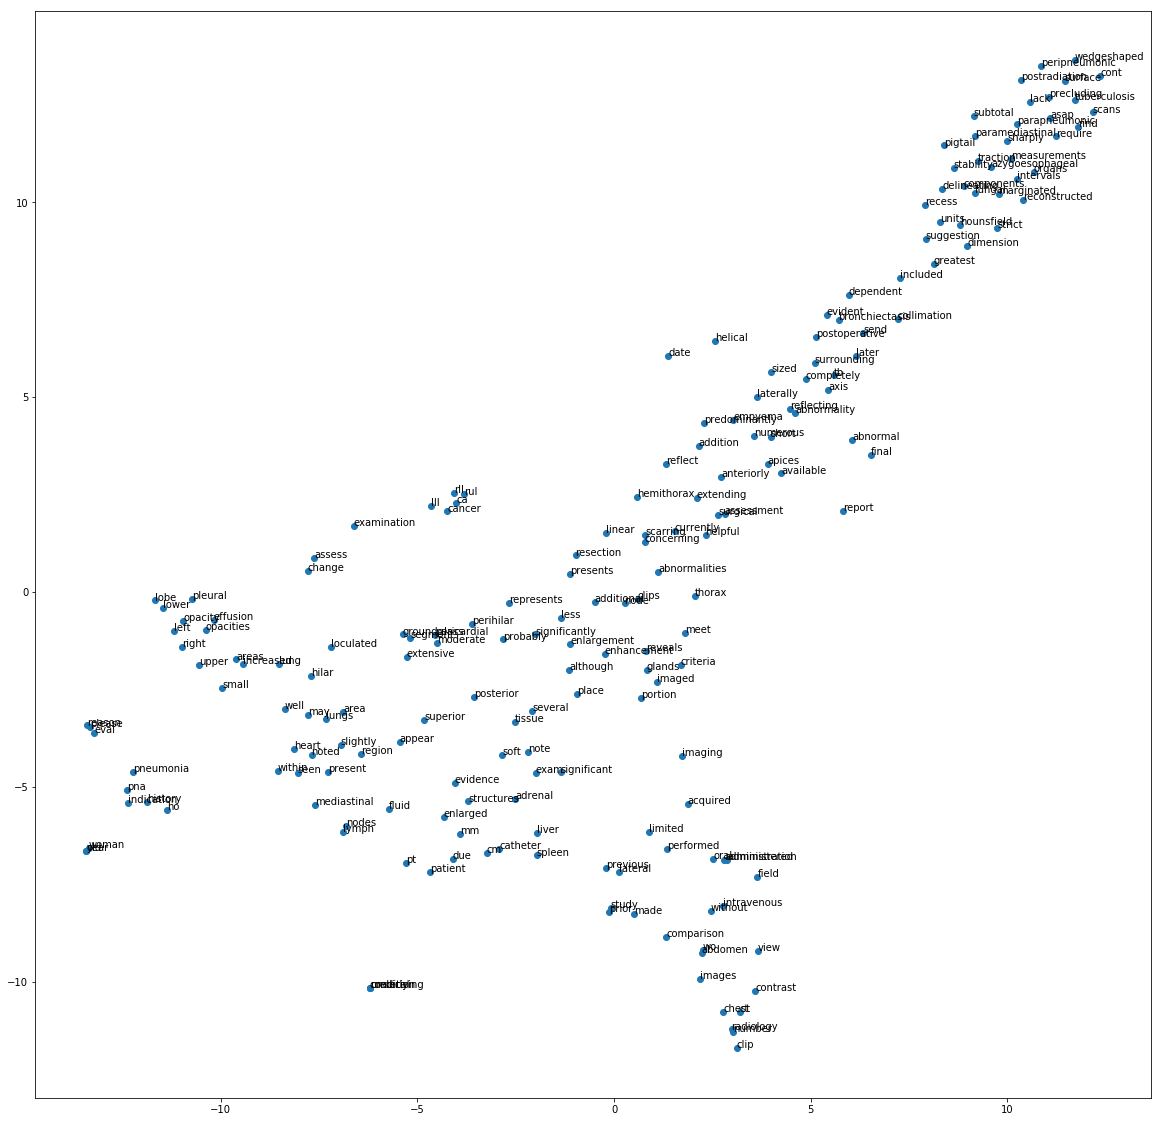

In [14]:
pneumonia_vocab = [k for (k, v) in pneumonia_model.wv.vocab.items()]
plot_embeddings(pneumonia_model, pneumonia_vocab[:200])